In [40]:
s = np.ones((Lt, Lx), dtype=int)
s.shape

(256, 128)

In [4]:
'''
Code to write configs for 2d ising model and used lx=128 and ly=256

--- Simulation parameters ---
# K = 0.3                       # Coupling constant (inverse temperature)
# thermalization = 1_000_000    # Number of warm-up sweeps
# num_configs_total = 100_000    # Total number of configurations to save
# configs_per_chunk = 100       # Save this many before writing to disk
# separation = 1000             # Sweeps between saved configurations

'''

import numpy as np
from tqdm import tqdm

# # --- Lattice dimensions ---
Lx = 128                      # Spatial extent
Lt = 256                      # Temporal extent (acts like time)
K = 0.3                       # Coupling constant (inverse temperature)

# # --- Simulation parameters ---
thermalization = 1_000_000      # Number of warm-up sweeps
num_configs_total = 100000    # Total number of configurations to save
configs_per_chunk = 100       # Save this many before writing to disk
separation = 1000             # Sweeps between saved configurations

filename = "configurations_128x256_new.dat"

# # --- Initialize spins (all +1) ---
s = np.ones((Lt, Lx), dtype=int)

# # --- Helper to compute periodic neighbors ---
def neighbors(t, x):
    return [
         ((t + 1) % Lt, x),
         ((t - 1) % Lt, x),
         (t, (x + 1) % Lx),
         (t, (x - 1) % Lx)
     ]

# # --- Single-site Metropolis update ---
def update(s):
     t = np.random.randint(Lt)
     x = np.random.randint(Lx)

     spin = s[t, x]
     sum_neighbors = sum(s[nt, nx] for nt, nx in neighbors(t, x))
     delta_E = 2 * spin * sum_neighbors

     if delta_E <= 0 or np.random.rand() < np.exp(-K * delta_E):
         s[t, x] *= -1

# # --- Thermalization ---
print("Starting thermalization...")
for _ in tqdm(range(thermalization), desc="Thermalizing"):
     update(s)

 # --- Generate and save configurations ---
print("Saving configurations to disk...")
with open(filename, "w") as file:
    for _ in tqdm(range(num_configs_total // configs_per_chunk), desc="Generating configs"):
        chunk = []

        for _ in range(configs_per_chunk):
            for _ in range(separation):
                update(s)
            chunk.append(s.copy())

        for config in chunk:
            # Loop over spatial direction first, then time
            for x in range(Lx):          # space direction
                for t in range(Lt):      # time direction
                    file.write(f"{config[t, x]} ")
            file.write("\n")

Starting thermalization...


Thermalizing: 100%|███████████████| 1000000/1000000 [00:03<00:00, 320687.56it/s]


Saving configurations to disk...


Generating configs: 100%|███████████████████| 1000/1000 [16:03<00:00,  1.04it/s]


In [42]:
import numpy as np
import h5py
from tqdm import tqdm

# --- Lattice dimensions ---
Lx = 128
Lt = 256
K = 0.3

# --- Simulation parameters ---
thermalization = 1_000_000
num_configs_total = 100_000
configs_per_chunk = 100
separation = 1000

filename = "configurations_128x256_new.h5"

# --- Initialize spins ---
s = np.ones((Lt, Lx), dtype=int)

# --- Helper to compute periodic neighbors ---
def neighbors(t, x):
    return [
        ((t + 1) % Lt, x),
        ((t - 1) % Lt, x),
        (t, (x + 1) % Lx),
        (t, (x - 1) % Lx)
    ]

# --- Single-site Metropolis update ---
def update(s):
    t = np.random.randint(Lt)
    x = np.random.randint(Lx)

    spin = s[t, x]
    sum_neighbors = sum(s[nt, nx] for nt, nx in neighbors(t, x))
    delta_E = 2 * spin * sum_neighbors

    if delta_E <= 0 or np.random.rand() < np.exp(-K * delta_E):
        s[t, x] *= -1

# --- Thermalization ---
print("Starting thermalization...")
for _ in tqdm(range(thermalization), desc="Thermalizing"):
    update(s)

# --- Create HDF5 dataset ---
with h5py.File(filename, "w") as f:
    # Create a dataset to hold all configurations
    dset = f.create_dataset("configs",
                            shape=(num_configs_total, Lx, Lt),
                            dtype=np.int8)

    idx = 0
    print("Generating and saving configurations...")
    for _ in tqdm(range(num_configs_total // configs_per_chunk), desc="Generating configs"):
        chunk = []

        # Generate configs_per_chunk configurations
        for _ in range(configs_per_chunk):
            for _ in range(separation):
                update(s)
            chunk.append(s.copy())

        # Convert chunk to array of shape (configs_per_chunk, Lx, Lt)
        chunk_arr = np.array(chunk, dtype=np.int8).transpose(0, 2, 1)  # (configs, Lx, Lt)
        # Write to HDF5 dataset
        dset[idx:idx+configs_per_chunk] = chunk_arr
        idx += configs_per_chunk


Starting thermalization...


Thermalizing: 100%|███████████████| 1000000/1000000 [00:03<00:00, 320131.62it/s]


Generating and saving configurations...


Generating configs: 100%|███████████████████| 1000/1000 [05:18<00:00,  3.14it/s]


In [1]:
import h5py
import numpy as np

filename = "configurations_128x256_new.h5"

with h5py.File(filename, "r") as f:
    print("Keys in file:", list(f.keys()))  # Should show ['configs']
    
    data = f["configs"]        # This is an h5py dataset
    print("Dataset shape:", data.shape)   # Should be (100000, 128, 256)
    
    # Example: read the first configuration
    first_config = data[0]     # shape (128, 256)
    print("First configuration shape:", first_config.shape)
    print("First 15 rows and 25 columns of first config:\n", first_config[:15, :25])
    
    # Example: read 5 random configurations
    idx = np.random.randint(0, data.shape[0], size=5)
    sample_configs = data[idx]  # shape (5, 128, 256)
    print("Shapes of 5 sampled configs:", sample_configs.shape)



Keys in file: ['configs']
Dataset shape: (100000, 128, 256)
First configuration shape: (128, 256)
First 15 rows and 25 columns of first config:
 [[ 1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1
  -1]
 [-1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1
   1]
 [ 1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1
  -1]
 [-1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1
  -1]
 [-1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1
  -1]
 [-1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1
  -1]
 [ 1  1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1 -1
  -1]
 [ 1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1
  -1]
 [ 1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1 -1  1
   1]
 [ 1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1  1 -1 -1 -1
   1]
 [ 1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1 -1

TypeError: Indexing elements must be in increasing order

In [36]:
import numpy as np
from tqdm import tqdm

def bin_correlation(configs_file, max_tau, bin_size, output_file=None):

    """
    Compute binned two-point correlation functions from saved spin configurations.

    This function reads Ising spin configurations from disk, performs a Fourier
    transform along the spatial direction to project to zero-momentum (p=0),
    and computes time-separated correlators C(tau). Configurations are grouped
    into bins of size `bin_size` to reduce statistical correlations and obtain
    binned estimates of the correlators.

    Parameters:
    -----------
    configs_file : str
        Path to the file containing saved configurations (each row is one config).
    max_tau : int
        Maximum temporal separation τ to compute the correlator for.
    bin_size : int
        Number of configurations per bin (must divide total number of configs).
    output_file : str, optional
        If provided, save the real and imaginary parts of the binned correlators
        to this file in text format.

    Returns:
    --------
    C_binned : np.ndarray, shape (num_bins, max_tau)
        Array of complex-valued correlators averaged within each bin. The number
        of bins is determined by (total_configs // bin_size).
    """

    # Code to check total number of configs
    print("Counting total number of configurations...")
    with open(configs_file, "r") as f:
         num_configs = sum(1 for _ in f)

    # Making number of bins
    num_bins = num_configs // bin_size

    print(f"Found {num_configs} configs, forming {num_bins} bins of size {bin_size}")

    # Make binned correlators
    C_binned = np.zeros((num_bins, max_tau), dtype=np.complex64)
    counts = np.zeros(num_bins, dtype=np.int32)

    print("Processing configurations and computing correlators...")
    with open(configs_file, "r") as f:
        for i, line in enumerate(tqdm(f, total=num_configs, desc="Binning")):
            print("Printing line:",line)
            # print("Printing line shape:",line.shape)
            # conf = np.fromstring(line, sep=' ').reshape(128, 256)  # (Lx, Lt)
            # print('Config data: ',)
            # Fourier along spatial direction
            # ft_conf = np.fft.fft(conf, axis=0)
            # print("ft_config",ft_conf)

            # Zero-momentum projection
            # ft_p0 = ft_conf[0, :]  # shape: (Lt,)
            # print(ft_p0)
            # print("First run done")
            
            # conf = np.fromstring(line, sep=' ').reshape(256, 128)
            # ft_conf = np.fft.fft(conf, axis=1)
            # ft_p0 = ft_conf[:, 0]  # shape: (256,)

            # C_temp = np.zeros(max_tau, dtype=np.complex64)
            # for tau in range(max_tau):
            #     prod = ft_p0[tau:] * np.conj(ft_p0[:256 - tau])
            #     C_temp[tau] = np.mean(prod)

            # b = i // bin_size
            # # Normalizing C_binned by dividing by Lx = 128
            # C_binned[b] += C_temp 
            # counts[b] += 1

    # # Normalize the binned values
    # C_binned /= counts[:, None]

    # Save to file 
    if output_file is not None:
        print(f"Saving binned correlators to '{output_file}'...")
        np.savetxt(output_file, C_binned.real, 
                   header="Columns: C(0) C(1) ...", fmt="%.10e")

    return C_binned



In [12]:
import numpy as np

def jackknife_mean_error(data):
    """
    Perform jackknife resampling to estimate the mean and its statistical error.

    Parameters:
    -----------
    data : np.ndarray
        1D array of binned or correlated data (e.g., bin means).

    Returns:
    --------
    mean : float
        The mean of the data.
    error : float
        The jackknife error (standard error) on the mean.
    """
    n = len(data)

    jackknife_samples = np.empty(n)

    total_sum = np.sum(data)
    for i in range(n):
        jackknife_samples[i] = (total_sum - data[i]) / (n - 1)

    mean = np.mean(jackknife_samples)
    error = np.sqrt((n - 1) * np.mean((jackknife_samples - mean)**2))

    return mean, error

    

In [18]:
print(C_binned)

[[2208.8298  +0.j 1172.6754  +0.j  642.78296 +0.j ... -325.82275 +0.j
   396.39062 +0.j 1152.4062  +0.j]
 [2112.999   +0.j 1083.186   +0.j  549.6442  +0.j ...  362.53088 +0.j
   438.45312 +0.j  988.375   +0.j]
 [2214.8003  +0.j 1178.6742  +0.j  605.72784 +0.j ...  182.89581 +0.j
    93.859375+0.j  652.34375 +0.j]
 ...
 [2289.3584  +0.j 1224.4065  +0.j  645.3004  +0.j ... -126.78128 +0.j
   117.421875+0.j 1050.8125  +0.j]
 [2282.6519  +0.j 1244.1577  +0.j  696.4876  +0.j ...   52.25005 +0.j
   103.      +0.j  313.3125  +0.j]
 [2355.6462  +0.j 1302.156   +0.j  755.7805  +0.j ... -199.56255 +0.j
    94.15625 +0.j  856.21875 +0.j]]


In [19]:
C_mean = np.zeros(C_binned.shape[1], dtype=np.float64)
C_error = np.zeros(C_binned.shape[1], dtype=np.float64)

for tau in range(C_binned.shape[1]):
    mean, err = jackknife_mean_error(C_binned[:, tau].real)  # use real part
    C_mean[tau] = mean
    C_error[tau] = err


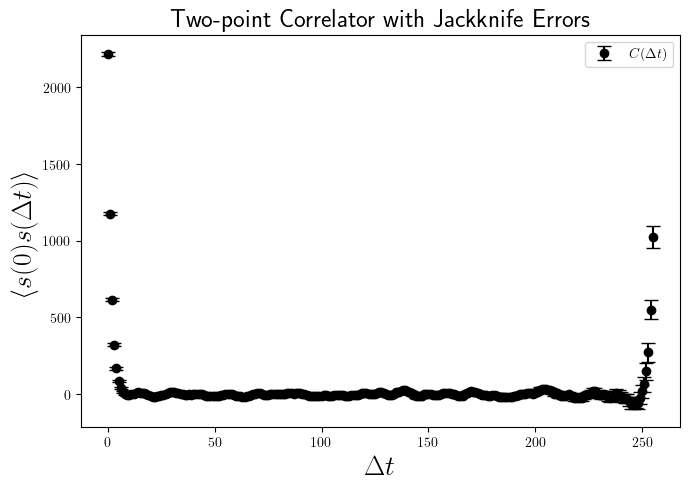

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"
import numpy as np

# Assume you already have:
# C_mean : array of shape (max_tau,)
# C_error : array of shape (max_tau,)

deltas = np.arange(len(C_mean))

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(
    deltas,
    C_mean.real,                # use real part of correlator
    yerr=C_error,
    color="k",
    fmt="o",
    capsize=5,
    label=r"$C(\Delta t)$"
)

ax.set_xlabel(r"$\Delta t$", fontsize=20)
ax.set_ylabel(r"$\ev{s(0)s(\Delta t)}$", fontsize=20)
ax.set_title("Two-point Correlator with Jackknife Errors", fontsize=18)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
use curve_fit for by using C_mean , C_error for the properties

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def E_theoretical(p, L=128, a=1.0, k=0.3):
    J = k
    B = 0.5 * np.log(np.tanh(k))
    return a**2 * np.sqrt(J**2 + B**2 - 2 * J * B * np.cos(p))

# Theoretical values at same momenta
L = 128
n_max = int((10 * L) / (4 * np.pi))  # since p = 4πn / L

n_vals = np.arange(0, n_max + 1)   
p_vals = 2 * n_vals * (2 * np.pi / L)
E_vals = E_theoretical(p_vals, L=128, k=0.3)

# Plot
plt.plot(p_vals, E_vals, 'r--', label="Theoretical $E(p)$")

plt.xlabel(r"$|p|$")
plt.ylabel(r"$E(p)$")
plt.title("Dispersion Relation with Jackknife Error Bars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()